In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
import numpy as np
import pandas as pd

from os.path import join

import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

%matplotlib inline

In [2]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
scores = pd.read_excel(join(eCON,'STAIscores/scores.xlsx'))
scores.rename(columns={'SCORING':'TRAIT'},inplace=True)
scores.drop(columns=['PAIR SCORE'],inplace=True)
scores['SubID'] = scores['SubID'].apply(lambda name: ''.join(name.strip().split("_")))

# **Right BST: Anxiety analysis**

In [3]:
# Choose an roi from the list above
roi = 'rBNST'

In [4]:
# Load the data that contains shock betas for all participants
beta_df = pd.read_csv('Individual_betas_from_ROI_analysis_S_buttonPress.csv')
beta_df.head()

,Pair,Subject,Group,ROI,beta
0,P00,CON001,control,rBNST,0.640981
1,P00,CON031,uncontrol,rBNST,1.259554
2,P01,CON002,control,rBNST,0.757035
3,P01,CON021,uncontrol,rBNST,0.063796
4,P02,CON003,control,rBNST,0.583921


In [5]:
# Some dataframe manipulations to put all the information like shock betas, behavioral scores within a single df

tmp_df = beta_df[beta_df['ROI']==roi][['Pair','Subject','Group','beta']].reset_index(drop=True)
tmp_df.rename(columns={'beta':'shock: {}'.format(roi)},inplace=True)

In [6]:
# Pivoting creates hirarchical columns which convert all objects to non-null objects
pair_info_df = tmp_df.pivot(columns='Group',values=['Subject','shock: {}'.format(roi)],index='Pair')
pair_info_df.head()

Subject           shock: rBNST            
Group control uncontrol      control   uncontrol
Pair                                            
P00    CON001    CON031     0.640981     1.25955
P01    CON002    CON021     0.757035   0.0637963
P02    CON003    CON022     0.583921  0.00688493
P03    CON004    CON030     0.262793    0.358607
P04    CON005    CON023     0.686931    0.851783

In [7]:
# Adding a column with yoked-difference
pair_info_df[('shock: {}'.format(roi),'uncon-con')] = pair_info_df.loc[:,('shock: {}'.format(roi),'uncontrol')] - pair_info_df.loc[:,('shock: {}'.format(roi),'control')]
pair_info_df.rename(columns={'Subject':'SubID'},inplace=True)
pair_info_df.head()

SubID           shock: rBNST                       
Group control uncontrol      control   uncontrol  uncon-con
Pair                                                       
P00    CON001    CON031     0.640981     1.25955   0.618573
P01    CON002    CON021     0.757035   0.0637963  -0.693239
P02    CON003    CON022     0.583921  0.00688493  -0.577036
P03    CON004    CON030     0.262793    0.358607  0.0958138
P04    CON005    CON023     0.686931    0.851783   0.164852

In [8]:
new_score_df = pd.DataFrame()
for i,row in pair_info_df.iterrows():
    conTrait = scores[scores['SubID'] == row[('SubID','control')]]['TRAIT'].values[0]
    unconTrait = scores[scores['SubID'] == row[('SubID','uncontrol')]]['TRAIT'].values[0]
    
    conState = scores[scores['SubID'] == row[('SubID','control')]]['STATE'].values[0]
    unconState = scores[scores['SubID'] == row[('SubID','uncontrol')]]['STATE'].values[0]
    
    tmp_df = pd.DataFrame([i,row[('SubID','uncontrol')],row[('SubID','control')],
                           unconTrait,conTrait,unconTrait-conTrait,np.mean([unconTrait,conTrait]),
                           unconState,conState,unconState-conState,np.mean([unconState,conState])],
                          index=['Pair',('SubID','uncontrol'),('SubID','control'),
                                  ('TRAIT','uncontrol'),('TRAIT','control'),('TRAIT','uncon-con'),('TRAIT','mean'),
                                  ('STATE','uncontrol'),('STATE','control'),('STATE','uncon-con'),('STATE','mean')]).T
    
    new_score_df = pd.concat([new_score_df,tmp_df],axis=0)
    
new_score_df.set_index('Pair',inplace=True)


new_score_df.columns = pd.MultiIndex.from_tuples(new_score_df.columns)
final_df = pair_info_df.merge(new_score_df,left_on=[('SubID','uncontrol'), ('SubID','control')],right_on=[('SubID','uncontrol'), ('SubID','control')])
final_df.head()

SubID           shock: rBNST                            TRAIT          \
Group control uncontrol      control   uncontrol  uncon-con uncontrol control   
0      CON001    CON031     0.640981     1.25955   0.618573        27      27   
1      CON002    CON021     0.757035   0.0637963  -0.693239        36      27   
2      CON003    CON022     0.583921  0.00688493  -0.577036        37      36   
3      CON004    CON030     0.262793    0.358607  0.0958138        24      21   
4      CON005    CON023     0.686931    0.851783   0.164852        33      33   

                          STATE                          
Group uncon-con  mean uncontrol control uncon-con  mean  
0             0    27        22      24        -2    23  
1             9  31.5        30      26         4    28  
2             1  36.5        29      26         3  27.5  
3             3  22.5        20      21        -1  20.5  
4             0    33        32      26         6    29

## **Distribution of scores**

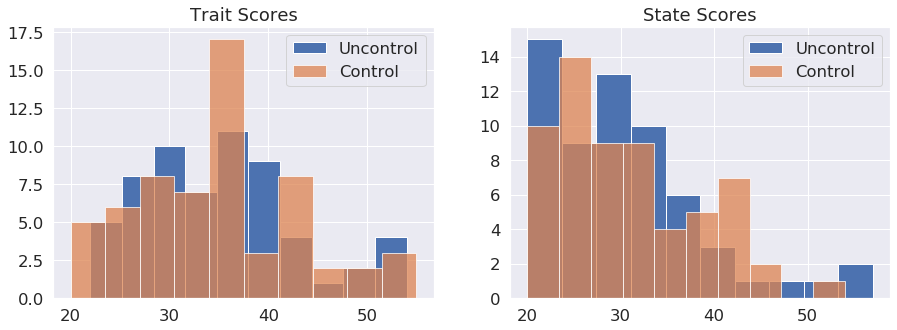

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
_=plt.hist(new_score_df[('TRAIT','uncontrol')],label='Uncontrol')
_=plt.hist(new_score_df[('TRAIT','control')],alpha=0.75,label='Control')
plt.title('Trait Scores')
plt.legend()

plt.subplot(1,2,2)
_=plt.hist(new_score_df[('STATE','uncontrol')],label='Uncontrol')
_=plt.hist(new_score_df[('STATE','control')],alpha=0.75,label='Control')
plt.title('State Scores')
plt.legend()

## **Permutation test**

In [12]:
from scipy.stats import ttest_ind

In [13]:
final_df.columns

MultiIndex(levels=[['STATE', 'SubID', 'TRAIT', 'shock: rBNST'], ['control', 'mean', 'uncon-con', 'uncontrol']],
           codes=[[1, 1, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0], [0, 3, 0, 3, 2, 3, 0, 2, 1, 3, 0, 2, 1]],
           names=[None, 'Group'])

38

In [16]:
def exact_mc_perm_test(xs, ys, nmc):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc


print('Permutation Test')
print('Trait p-val: %.4f' %(exact_mc_perm_test(final_df[('TRAIT','uncontrol')],final_df[('TRAIT','control')],50000)))
print('State p-val: %.4f' %(exact_mc_perm_test(final_df[('STATE','uncontrol')],final_df[('STATE','control')],50000)))
print('Ind. Samples T-test')
print('Trait p-val: %.4f' %(ttest_ind(final_df[('TRAIT','uncontrol')],final_df[('TRAIT','control')])[1]))
print('State p-val: %.4f' %(ttest_ind(final_df[('STATE','uncontrol')],final_df[('STATE','control')])[1]))

Permutation Test
Trait p-val: 0.9625
State p-val: 0.7574
Ind. Samples T-test
Trait p-val: 0.4981
State p-val: 1.0000


In [17]:
for col in ['shock: {}'.format(roi),'TRAIT','STATE']:
    final_df[col] = final_df[col].astype(float)

In [18]:
lr_df = final_df[[('shock: {}'.format(roi),'uncon-con'),
                  ('TRAIT','mean'),('TRAIT','uncon-con'),
                  ('STATE','mean'),('STATE','uncon-con')]]

lr_df.head()

shock: rBNST TRAIT           STATE          
Group    uncon-con  mean uncon-con  mean uncon-con
0         0.618573  27.0       0.0  23.0      -2.0
1        -0.693239  31.5       9.0  28.0       4.0
2        -0.577036  36.5       1.0  27.5       3.0
3         0.095814  22.5       3.0  20.5      -1.0
4         0.164852  33.0       0.0  29.0       6.0

## **Corrleations and VIFs**

/home/climbach/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


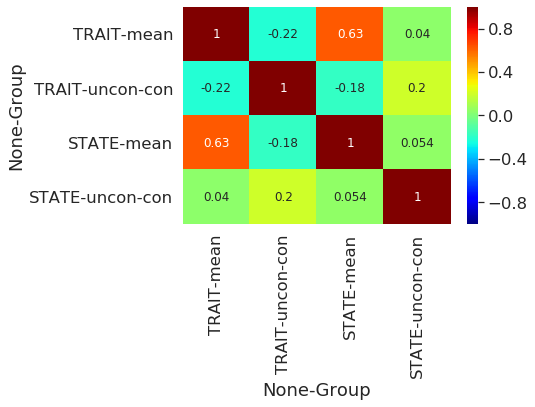

In [19]:
sns.heatmap(lr_df.drop(columns='shock: {}'.format(roi)).corr(),vmin=-1,vmax=1,cmap='jet',annot=True,annot_kws={'size':12})

In [20]:
## VIFs
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_for_VIF = lr_df.drop(columns='shock: {}'.format(roi)).copy()
df_for_VIF = sm.add_constant(df_for_VIF)
VIF_df = pd.DataFrame()
VIF_df['Feature'] = df_for_VIF.columns
VIF_df['VIF'] = [variance_inflation_factor(df_for_VIF.values, i) for i in range(df_for_VIF.shape[1])]
VIF_df[VIF_df['Feature']!='const']

/home/climbach/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Feature,VIF
1,"(TRAIT, mean)",1.679359
2,"(TRAIT, uncon-con)",1.104454
3,"(STATE, mean)",1.653669
4,"(STATE, uncon-con)",1.052130


In [21]:
lr_df.head()

shock: rBNST TRAIT           STATE          
Group    uncon-con  mean uncon-con  mean uncon-con
0         0.618573  27.0       0.0  23.0      -2.0
1        -0.693239  31.5       9.0  28.0       4.0
2        -0.577036  36.5       1.0  27.5       3.0
3         0.095814  22.5       3.0  20.5      -1.0
4         0.164852  33.0       0.0  29.0       6.0

In [22]:
# Reformat the tupled column names for (TRAIT, uncon-con) (TRAIT, mean) (STATE, uncon-con) (STATE, mean)
col_to_drop = []
for col in lr_df.columns:
    if type(col) is tuple:
        
        col_to_drop.append(col)
        
        hl, ll = col
        lr_df['_'.join([hl.split()[-1],ll])] = lr_df[col]
        print(hl.split()[-1],ll)
        
lr_df.drop(columns=col_to_drop,inplace=True)
lr_df = lr_df.droplevel(level=1,axis=1)

/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


rBNST uncon-con
TRAIT mean
TRAIT uncon-con
STATE mean
STATE uncon-con


/home/climbach/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
lr_df.head()

,rBNST_uncon-con,TRAIT_mean,TRAIT_uncon-con,STATE_mean,STATE_uncon-con
0,0.618573,27.0,0.0,23.0,-2.0
1,-0.693239,31.5,9.0,28.0,4.0
2,-0.577036,36.5,1.0,27.5,3.0
3,0.095814,22.5,3.0,20.5,-1.0
4,0.164852,33.0,0.0,29.0,6.0


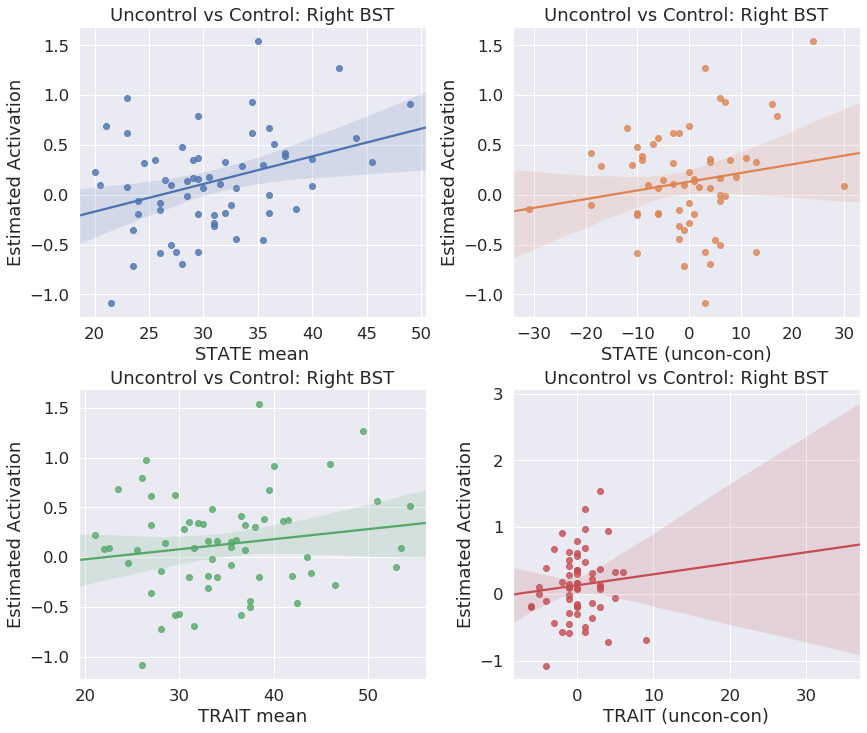

In [24]:
anxiety = {'STATE_mean':'STATE mean','STATE_uncon-con':'STATE (uncon-con)','TRAIT_mean':'TRAIT mean','TRAIT_uncon-con':'TRAIT (uncon-con)'}
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(14,12),sharex=False,sharey=False)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.25,wspace=0.25)
for i, item in enumerate(anxiety.items()):
    x, col = item
    sns.regplot(x=x,y='rBNST_uncon-con',data=lr_df,ax=axes[i])
    axes[i].set_xlabel(' '.join(col.split('_')))
    axes[i].set_ylabel('Estimated Activation')
    axes[i].set_title('Uncontrol vs Control: Right BST')
#plt.tight_layout()
#plt.savefig('data/uncon_v_control_rBNST_{}'.format(x),dpi=600)

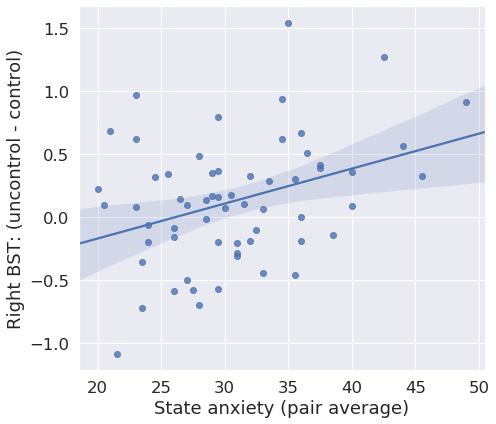

In [25]:
plt.figure(figsize=(7,6))
sns.regplot(x='STATE_mean',y='rBNST_uncon-con',data=lr_df)
plt.xlabel('State anxiety (pair average)')
plt.ylabel('Right BST: (uncontrol - control)')
plt.tight_layout()
plt.savefig('data/rBNST_state_uncon_v_con.png',dpi=600)

In [26]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [27]:
y = lr_df['rBNST_uncon-con']
X = lr_df[['TRAIT_mean','TRAIT_uncon-con',
           'STATE_mean','STATE_uncon-con']]

ss = StandardScaler()
X_norm = pd.DataFrame(ss.fit_transform(X),columns=X.columns)

X_norm = sm.add_constant(X_norm)
model = sm.OLS(y,X_norm)
results = model.fit()

/home/climbach/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## **Linear regression OLS:**
- y: shock beta
- X: TRAIT (mean and uncon-con), STATE (mena and uncon-con)

In [28]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        rBNST_uncon-con   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     2.932
Date:                Fri, 01 May 2020   Prob (F-statistic):             0.0285
Time:                        13:25:31   Log-Likelihood:                -37.328
No. Observations:                  61   AIC:                             84.66
Df Residuals:                      56   BIC:                             95.21
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1292      0.060     

Text(0.5, 1.0, 'Real vs. Predicted')

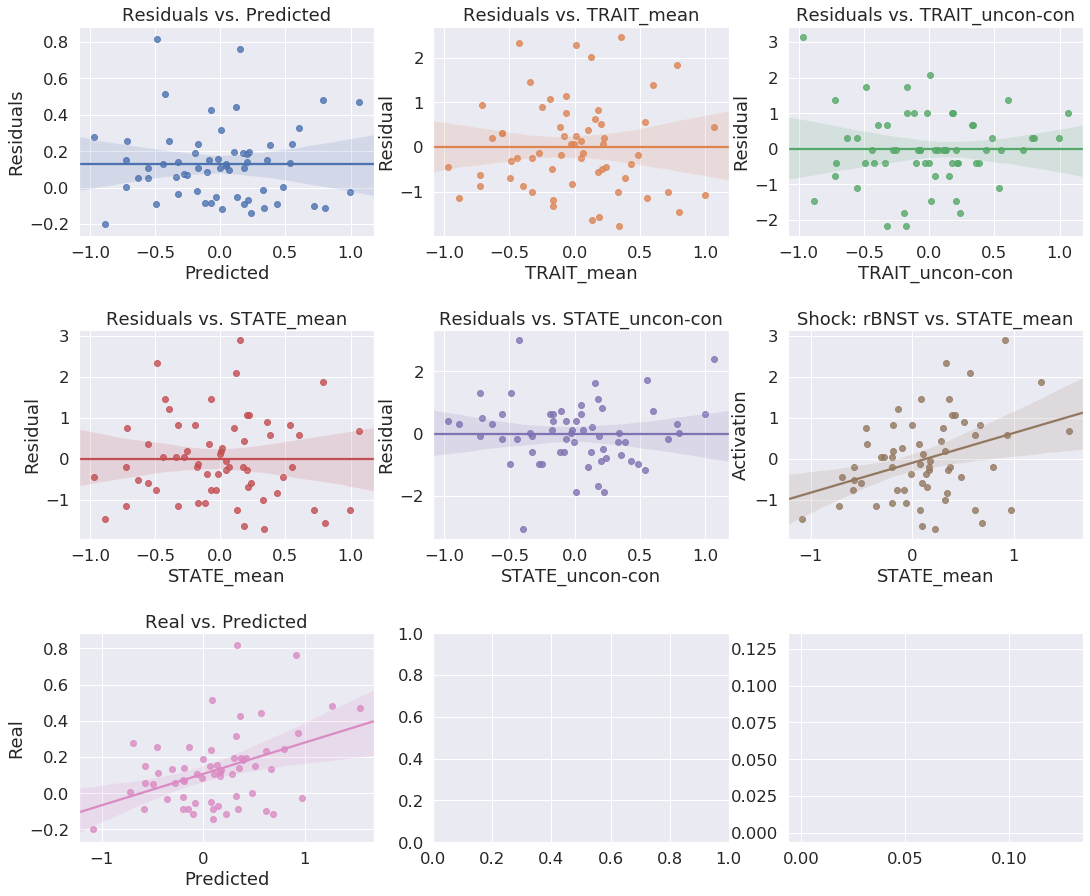

In [29]:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(18,15),sharey=False)
fig.subplots_adjust(wspace=None, hspace=0.45)

axes = axes.flatten()

sns.regplot(results.resid,results.fittedvalues,ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs. Predicted')

sns.regplot(results.resid,X_norm.iloc[:,1],ax=axes[1])
axes[1].set_xlabel('{}'.format(X_norm.columns[1]))
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals vs. {}'.format(X_norm.columns[1]))

sns.regplot(results.resid,X_norm.iloc[:,2],ax=axes[2])
axes[2].set_xlabel('{}'.format(X_norm.columns[2]))
axes[2].set_ylabel('Residual')
axes[2].set_title('Residuals vs. {}'.format(X_norm.columns[2]))

sns.regplot(results.resid,X_norm.iloc[:,3],ax=axes[3])
axes[3].set_xlabel('{}'.format(X_norm.columns[3]))
axes[3].set_ylabel('Residual')
axes[3].set_title('Residuals vs. {}'.format(X_norm.columns[3]))

sns.regplot(results.resid,X_norm.iloc[:,4],ax=axes[4])
axes[4].set_xlabel('{}'.format(X_norm.columns[4]))
axes[4].set_ylabel('Residual')
axes[4].set_title('Residuals vs. {}'.format(X_norm.columns[4]))

sns.regplot(y,X_norm.iloc[:,3],ax=axes[5])
axes[5].set_xlabel('{}'.format(X_norm.columns[3]))
axes[5].set_ylabel('Activation'.format())
axes[5].set_title('Shock: {0} vs. {1}'.format(roi,X_norm.columns[3]))

sns.regplot(y,results.fittedvalues,ax=axes[6])
axes[6].set_xlabel('Predicted')
axes[6].set_ylabel('Real')
axes[6].set_title('Real vs. Predicted')
